In [69]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

# Model Imports
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# KMeans Clustering

## Generating Data

In [31]:
# Variables

n_data = 1000
seed = 1
n_clusters = 4

### Generating Blob Data

In [32]:
# Generate random Gaussian blobs

blobs, blob_labels = make_blobs(
  n_samples=n_data,     # Number of data points
  n_features=2,         # Number of features
  centers=n_clusters,   # Number of clusters (labels)
  random_state=seed, 
)

In [33]:
# Labels

print(f"Labels: {set(blob_labels)}")
print(f"Number of Labels: {len(set(blob_labels))}")

Labels: {0, 1, 2, 3}
Number of Labels: 4


In [34]:
# Quick view of first 5 data points

np.hstack([blobs[0:5], blob_labels[0:5].reshape(-1,1)])

array([[-10.45765533,  -3.30899488,   1.        ],
       [ -5.90962043,  -7.80717036,   2.        ],
       [ -1.00497975,   4.35530142,   0.        ],
       [ -6.63784922,  -4.52085249,   3.        ],
       [ -6.3466658 ,  -8.89940182,   2.        ]])

### Generating Uniform Data

In [35]:
# Generate data uniformly

uniform = np.random.rand(
  n_data,         # Number of observations
  2,              # Number of columns
)

In [36]:
# Viewing the data

np.hstack([uniform[0:5], blob_labels[0:5].reshape(-1,1)])

array([[0.85642141, 0.90798357, 1.        ],
       [0.69329035, 0.99783525, 2.        ],
       [0.48033602, 0.51081659, 0.        ],
       [0.58000331, 0.4560882 , 3.        ],
       [0.94662556, 0.01219671, 2.        ]])

## Applying KMeans

### Applying KMeans to Blob Data

In [37]:
# Creating the KMeans object
gaussian_kmeans = KMeans(
  n_clusters=n_clusters,
  random_state=seed,
)

# Fitting the KMeans to the data
clusters_blob = gaussian_kmeans.fit_predict(blobs)

### Applying KMeans to Unifrom Data

In [38]:
# Creating the KMeans object
uniform_kmeans = KMeans(
  n_clusters=n_clusters,
  random_state=seed,
)

# Fitting the KMeans to the data
clusters_uniform = uniform_kmeans.fit_predict(uniform)

## Plotting the Data

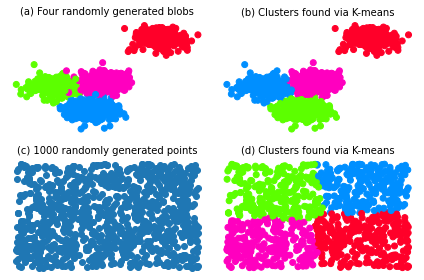

In [39]:
# Creating the figure
fig = plt.figure()

# Creating the first graph with blob data and true labels
plt.subplot(2,2,1)
plt.scatter(
  blobs[:,0], # First column of the blobs
  blobs[:,1], # Second column of blobs
  c=blob_labels, # Color it by label
  cmap='gist_rainbow'
)
plt.title("(a) Four randomly generated blobs", fontsize=10)
plt.axis("off")

# Creating the second graph with blob data and KMeans labels
plt.subplot(222)
plt.scatter(
  blobs[:, 0], 
  blobs[:, 1], 
  c=clusters_blob, 
  cmap='gist_rainbow'
)
plt.title("(b) Clusters found via K-means", fontsize=10)
plt.axis("off")

# Creating the third graph of uniform data
plt.subplot(223)
plt.scatter(uniform[:, 0], uniform[:, 1])
plt.title("(c) 1000 randomly generated points", fontsize=10)
plt.axis("off")

# Creating the fourth graph of uniform data and KMeans label
plt.subplot(224)
plt.scatter(uniform[:, 0], uniform[:, 1], c=clusters_uniform, cmap='gist_rainbow')
plt.title("(d) Clusters found via K-means", fontsize=10)
plt.axis("off")

plt.tight_layout()
plt.show()

# Swiss Roll

In [40]:
# Imports

from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets

## Generating Swiss Roll Data

In [41]:
X, color = datasets.make_swiss_roll(n_samples=1500)

## Applying KMeans

In [42]:
clusters_swiss_roll = KMeans(n_clusters=100, random_state=seed).fit_predict(X)

## Plotting Swiss Roll with KMeans Clusters

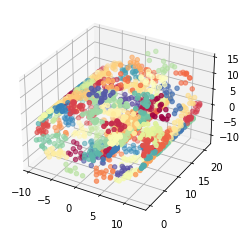

In [43]:
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters_swiss_roll, cmap='Spectral');

## k-Means Featurizer

In [44]:
class KMeansFeaturizer:
    """
    Transforms numeric data into k-means cluster membership

    This transformer runs k-means on the input data and converts each data point
    into the ID of the closest cluster. If a target variable is present, it is
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        """
        Initializing the parameters for KMeansFeaturizer

        Parameters:
        k: number of clusters
        target_scale: how much to scale the target variable ()
        """
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state

In [45]:
def fit(self, X, y=None):
    """
    Runs k-Means on the input data and finds centroids

    Parameters:
    X: the features
    y: the target (default is None)
    """
    if y is None: # If there is no target, run normal k-Means
        km_model = KMeans(
            n_clusters=self.k,
            n_init=20, # number of different sets of randomly chosen centroids
            random_state=self.random_state
        )

        km_model.fit(X)

        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self

    # If there is a target, scale target and include it with the input
    data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

    km_model_pretrain = KMeans(
        n_clusters=self.k,
        n_init=20,
        random_state=self.random_state
    )

    km_model_pretrain.fit(data_with_target)

    km_model = KMeans(
        n_clusters=self.k,
        init=km_model_pretrain.cluster_centers_[:,:2], # providing a method for initialization, in this case (n_clusters, n_features)
        n_init=1,
        max_iter=1 # maximum number of iterations K-Means should make
    )

    km_model.fit(X) # Fits the data

    self.km_model = km_model # Saving the model to the object

    self.cluster_centers_ = km_model.cluster_centers_ # Saving the cluster centers to the object

    return self

# Making the function part of the KMeansFeaturizer class
KMeansFeaturizer.fit = fit

In [46]:
def transform(self, X, y=None):
    """
    Outputs the closest cluster ID for each input data packet

    Parameters:
    X: features
    y: target (default is None)
    """
    clusters = self.km_model.predict(X)
    return clusters[:,np.newaxis]

# Making the function part of the KMeansFeaturizer class
KMeansFeaturizer.transform = transform

In [47]:
def fit_transform(self, X, y=None):
    """
    Fitting the data and using it to transform the data given X and y
    
    Parameters:
    X: features
    y: target (default is None)
    """
    self.fit(X,y)
    return self.transform(X,y)

# Making the function part of the KMeansFeaturizer class
KMeansFeaturizer.fit_transform = fit_transform

In [48]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons

In [49]:
# Creating moon dataset

training_data, training_labels = make_moons(
    n_samples=2000,
    noise=0.2,
)

In [50]:
kmf_hint = KMeansFeaturizer(k=100, target_scale=10).fit(training_data, training_labels)

In [51]:
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0).fit(training_data, training_labels)

In [52]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """
    Plots the Voronoi diagram of the k-means clusters overlaid with the data
    """
    ax.scatter(
        X[:, 0], 
        X[:, 1], 
        c=y, 
        cmap='Set1', 
        alpha=0.2
    )
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

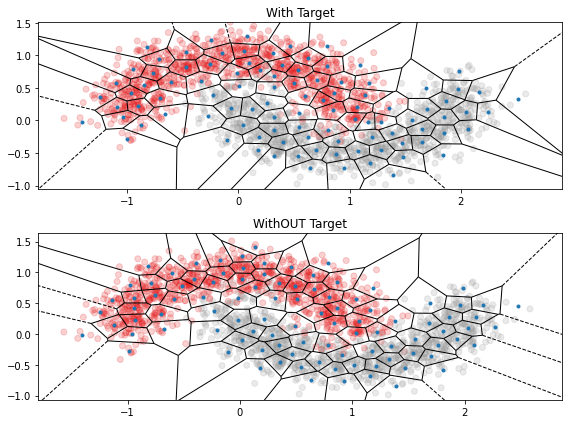

In [53]:
# Plotting the data

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, ax1)
kmeans_voronoi_plot(training_data, training_labels, kmf_no_hint.cluster_centers_, ax2)
ax1.set_title("With Target")
ax2.set_title("WithOUT Target")
plt.tight_layout();

In [55]:
# Generating test data

test_data, test_labels = make_moons(n_samples=2000, noise=0.3)

In [56]:
# Using Kmeans to generate cluster features

training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

In [62]:
# Combining data with the cluster features

training_with_cluster = np.hstack(
    [training_data, training_cluster_features]
)

test_with_cluster = np.hstack(
    (test_data, test_cluster_features)
)

In [67]:
# Logistic Regression model with cluster features

lr_cluster = LogisticRegression(random_state=seed).fit(
    training_with_cluster,
    training_labels
)

In [64]:
# Classifiers without cluster features

classifier_names = [
    'LR',
    'kNN',
    'RBF SVM',
    'Random Forest',
    'Boosted Trees',
]

classifiers = [
    LogisticRegression(random_state=seed),
    KNeighborsClassifier(5),
    SVC(
        gamma=2, 
        C=1
    ),
    RandomForestClassifier(
        max_depth=5, 
        n_estimators=10, 
        max_features=1
    ),
    GradientBoostingClassifier(
        n_estimators=10, 
        learning_rate=1.0, 
        max_depth=5
    )
]

In [65]:
# Training the classifiers

for model in classifiers:
    model.fit(training_data, training_labels)

In [71]:
def test_ROC(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = roc_curve(labels, predictions)
    return fpr, tpr

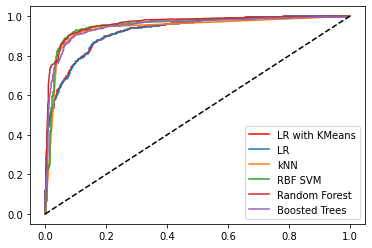

In [73]:
# 

## Creating the figure
plt.figure()

## Plotting the LR with cluster features
fpr_cluster, tpr_cluster = test_ROC(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'r-', label='LR with KMeans')

## Plotting the results of each classifier
for idx, model in enumerate(classifiers):
    fpr, tpr = test_ROC(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[idx])

## Plotting the baseline
plt.plot([0,1], [0,1], 'k--')
plt.legend();